In [1]:
import pandas
import numpy as np
import nltk
from nltk import word_tokenize
from nltk import RegexpTokenizer
from nltk import stem
from sklearn.dummy import DummyClassifier

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [3]:
path = 'SMSSpamCollection'

In [4]:
messages = pandas.read_csv(path, sep='\t',
                           names=["label", "message"])
print(messages.groupby('label').count())


       message
label         
ham       4825
spam       747


# Про датасет

In [5]:
print(messages.loc[messages['label'] == 'ham'].count()/messages.loc[messages['label'] == 'spam'].count())

label      6.45917
message    6.45917
dtype: float64


Датасет не сбалансирован -- неспама примерно в 6 раз больше. Посмотрим, что будет, если попытаться применить dummy classifier.

In [6]:
messages.loc[messages['label'] == 'ham'].count()/messages.count()

label      0.865937
message    0.865937
dtype: float64

Это получилась примерная мера полноты для dummy classifier. Показатель хороший (из-за того, что в выборке сильно больше неспама) , но для нашей задачи не подходит, потому что не выявляет спам. 

In [7]:
ham = messages.loc[messages['label'] == 'ham'][:747]
ham.count()

label      747
message    747
dtype: int64

Теперь неспама ровно столько же

In [8]:
spam = messages.loc[messages['label'] == 'spam']
new = pandas.concat([ham, spam])
new.describe()

,label,message
count,1494,1494
unique,2,1383
top,spam,"Sorry, I'll call later"
freq,747,6


In [9]:
def tokenize(text):
    return word_tokenize(text)

In [10]:
new['length'] = new['message'].map(lambda text: len(text))
print(new)

     label                                            message  length
0      ham  Go until jurong point, crazy.. Available only ...     111
1      ham                      Ok lar... Joking wif u oni...      29
3      ham  U dun say so early hor... U c already then say...      49
4      ham  Nah I don't think he goes to usf, he lives aro...      61
6      ham  Even my brother is not like to speak with me. ...      77
7      ham  As per your request 'Melle Melle (Oru Minnamin...     160
10     ham  I'm gonna be home soon and i don't want to tal...     109
13     ham  I've been searching for the right words to tha...     196
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!      35
16     ham                         Oh k...i'm watching here:)      26
17     ham  Eh u remember how 2 spell his name... Yes i di...      81
18     ham  Fine if thats the way u feel. Thats the way ...      56
20     ham          Is that seriously how you spell his name?      41
21     ham    I‘m go

### Смотрим на показатели при изначальных параметрах (токенизация со знаками препинания)

In [11]:
bow = CountVectorizer()
bow.fit_transform(new['message'])
bowed_messages = bow.transform(new['message'])
#print(bowed_messages)
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.957864864865 0.0142927324581
             precision    recall  f1-score   support

        ham       0.99      0.98      0.98       755
       spam       0.98      0.99      0.98       739

avg / total       0.98      0.98      0.98      1494



# Токенизация, которая не учитывает пунктуацию

In [13]:
from nltk import RegexpTokenizer
def tokenize1(text):    
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)


In [14]:
bow1 = CountVectorizer(tokenizer=RegexpTokenizer(r'\w+').tokenize)
bow1.fit_transform(new['message'])
bowed_messages = bow1.transform(new['message'])
naive_model1 = MultinomialNB()
naive_model1.fit(bowed_messages, new['label'])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model1.predict(bowed_messages), new['label']))

0.967252252252 0.0137693647717
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       764
       spam       0.97      0.99      0.98       730

avg / total       0.98      0.98      0.98      1494



Стало немного лучше. Оставим токенизацию без знаков препинания.

### Стемминг

In [16]:
from nltk.stem.snowball import EnglishStemmer

In [17]:
def tokenize2(text):
    stems = []
    for i in RegexpTokenizer(r'\w+').tokenize(text):
        stems.append(EnglishStemmer(ignore_stopwords=True).stem(i))            
    return stems

In [18]:
bow2 = CountVectorizer(tokenizer=tokenize2)
bow2.fit_transform(new['message'])
bowed_messages = bow2.transform(new['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.966576576577 0.0122249961805
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       766
       spam       0.97      0.99      0.98       728

avg / total       0.98      0.98      0.98      1494



Результат незначительно ухудшился

### Лемматизация

In [20]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#wordnet_lemmatizer.lemmatize('dogs')

In [21]:
def tokenize3(text):
    lemmas = []
    for i in RegexpTokenizer(r'\w+').tokenize(text):
        lemmas.append(wordnet_lemmatizer.lemmatize(i))            
    return lemmas

In [22]:
bow3 = CountVectorizer(tokenizer=tokenize3)
bow3.fit_transform(new['message'])
bowed_messages = bow3.transform(new['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.966558558559 0.0102710446997
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       763
       spam       0.97      0.99      0.98       731

avg / total       0.98      0.98      0.98      1494



Результат почти такой же, как со стеммингом. А лучше всего было без лемматизации/стемминга (с этой векторизацией).
### Посмотрим на стоп-слова

In [24]:
bow1 = CountVectorizer(tokenizer=RegexpTokenizer(r'\w+').tokenize, stop_words='english')
bow1.fit_transform(new['message'])
bowed_messages = bow1.transform(new['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.958531531532 0.0156599304791
             precision    recall  f1-score   support

        ham       0.99      0.98      0.99       751
       spam       0.98      0.99      0.99       743

avg / total       0.99      0.99      0.99      1494



Качество понизилось:( поэтому дальше без них.

### Теперь смотрим на векторизацию по tf-idf

In [26]:
bow4 = TfidfVectorizer(tokenizer=RegexpTokenizer(r'\w+').tokenize)
bow4.fit_transform(new['message'])
bowed_messages = bow4.transform(new['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.966567567568 0.00933973570801
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       765
       spam       0.97      0.99      0.98       729

avg / total       0.98      0.98      0.98      1494



Почти так же, как исходная векторизация, но всё же чуть хуже.

### tf-idf c токенизацией со знаками препинания

In [28]:
bow5 = TfidfVectorizer()
bow5.fit_transform(new['message'])
bowed_messages = bow5.transform(new['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.95854954955 0.0113576023115
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       760
       spam       0.97      0.99      0.98       734

avg / total       0.98      0.98      0.98      1494



### Со стеммингом

In [29]:
bow6 = TfidfVectorizer(tokenizer=tokenize2)
bow6.fit_transform(new['message'])
bowed_messages = bow6.transform(new['message'])
naive_model6 = MultinomialNB()
naive_model6.fit(bowed_messages, new['label'])
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model6.predict(bowed_messages), new['label']))

0.967252252252 0.0123722429947
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       766
       spam       0.97      0.99      0.98       728

avg / total       0.98      0.98      0.98      1494



### C лемматизацией

In [30]:
bow7 = TfidfVectorizer(tokenizer=tokenize3)
bow7.fit_transform(new['message'])
bowed_messages = bow7.transform(new['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, new['label'])
cv_results = cross_val_score(naive_model, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(naive_model.predict(bowed_messages), new['label']))

0.965891891892 0.00805641177172
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       764
       spam       0.97      0.99      0.98       730

avg / total       0.98      0.98      0.98      1494



Итоги: стоп-слова и выделение знаков препинания в качестве отдельных токенов понижают качество. Наиболее высокие результаты 
    показали Countvectorizer без стемминга и лемматизации и TfidfVectorizer со стеммингом.

Построим для них learning curve, ROC-curve.

### Learning curves, ROC-curve для CountVectorizer (без стемминга и лемматизации, знаки препинания не считаем токенами)

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

<module 'matplotlib.pyplot' from '/home/bombonjane/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

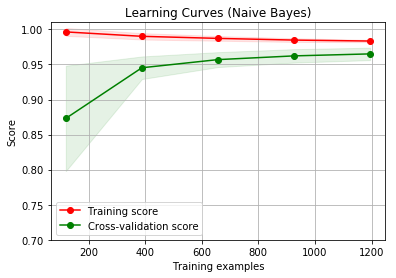

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = bowed_messages, new['label']
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = naive_model1
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


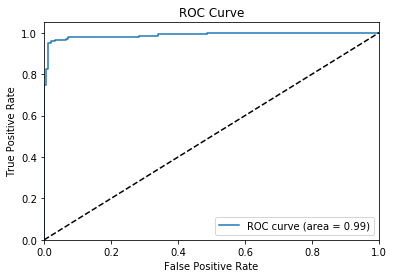

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
# shuffle and split training and test sets

X, y = bowed_messages, new['label']
y = label_binarize(y, classes=['ham', 'spam'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
naive_model1.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, naive_model1.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
#print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



### Learning curves, ROC-curve для TfidfVectorizer (со стеммингом, знаки препинания не считаем токенами)

/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

<module 'matplotlib.pyplot' from '/home/bombonjane/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

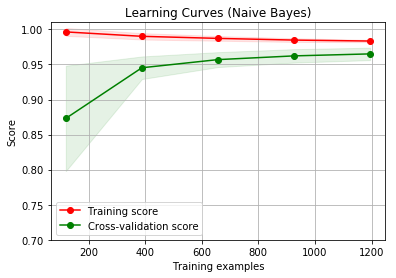

In [34]:
estimator = naive_model6
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


/home/bombonjane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


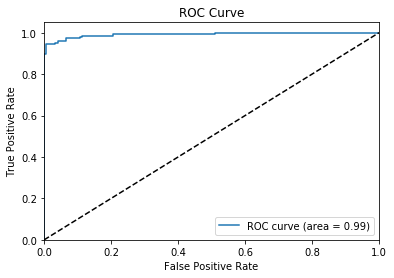

In [35]:
X, y = bowed_messages, new['label']
y = label_binarize(y, classes=['ham', 'spam'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
naive_model6.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, naive_model6.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
#print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Видим, что модели, построенные по байесу, практически не отличаются друг от друга и справляются с задачей. 
Площадь под Roc-кривой большая, следовательно, качество хорошее.

### А теперь попробуем дерево

In [36]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree1 = DecisionTreeClassifier()
tree1 = tree1.fit(bowed_messages, new['label'])

In [37]:
cv_results = cross_val_score(tree1, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(tree1.predict(bowed_messages), new['label']))

0.914981981982 0.0217542870663
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       747
       spam       1.00      1.00      1.00       747

avg / total       1.00      1.00      1.00      1494



Дерево справилось заметно хуже байеса.

### Learning curve, ROC-curve

<module 'matplotlib.pyplot' from '/home/bombonjane/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

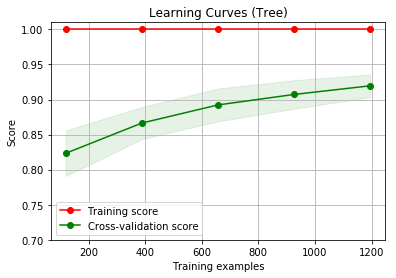

In [38]:
title = "Learning Curves (Tree)"
estimator = tree1
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

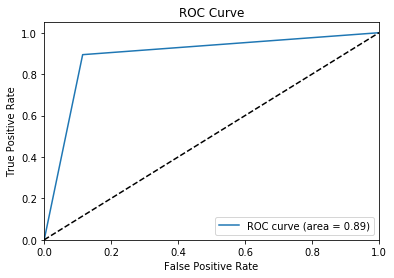

In [39]:
X, y = bowed_messages, new['label']
y = label_binarize(y, classes=['ham', 'spam'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
tree1.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, tree1.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
#print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

По Learning curve видно, что дерево переобученное (на тренировочной выборке 100%, на тестовой гораздо меньше), либо надо увеличить выборку.
Поэтому и качество хуже. Площадь под Roc-curve меньше, чем у байеса,TP< FP, следовательно, спам не всегда распознаётся. 

### Лес

In [40]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier()
rforest.fit(bowed_messages, new['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [41]:
cv_results = cross_val_score(rforest, bowed_messages, new['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(rforest.predict(bowed_messages), new['label']))

0.939126126126 0.0168720267576
             precision    recall  f1-score   support

        ham       1.00      0.99      1.00       751
       spam       0.99      1.00      1.00       743

avg / total       1.00      1.00      1.00      1494



Лес тоже справился хуже, чем наивный байес.

### Learning curve и ROC-curve

<module 'matplotlib.pyplot' from '/home/bombonjane/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

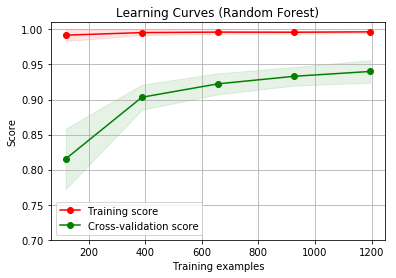

In [42]:
X, y = bowed_messages, new['label']
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = rforest
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


/home/bombonjane/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


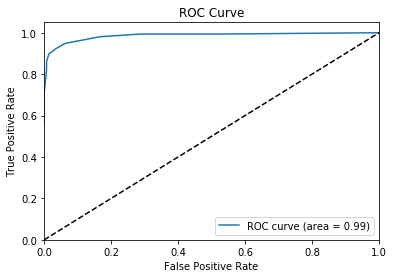

In [43]:
X, y = bowed_messages, new['label']
y = label_binarize(y, classes=['ham', 'spam'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
rforest.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, rforest.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
#print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Лес тоже переобучился/недостаточно данных в выборке (training score -- единица на learning curve, a cv score маленький). Площадь под Roc-curve больше, чем у дерева, почти идентичная модели с байесом.

### Другие признаки

In [44]:
from collections import Counter
import re
bow = CountVectorizer()
bow.fit_transform(new[new['label'] == 'spam']['message'])
count1 = Counter(bow.vocabulary_.keys())
list_spam = sorted(bow.vocabulary_, key=bow.vocabulary_.get, reverse=True) 
bow.fit_transform(new[new['label'] == 'ham']['message'])
count1 = Counter(bow.vocabulary_.keys())
list_ham = sorted(bow.vocabulary_, key=bow.vocabulary_.get, reverse=True)
really_spam = set(list_spam)-set(list_ham)
new['exclamation'] = new.apply(lambda x: sum (i == '!' for i in x['message']), axis=1)
new['question'] = new.apply(lambda x: sum (i == '?' for i in x['message']), axis=1)
new['capslock'] = new.apply(lambda x: sum (i.isupper() for i in x['message']), axis=1)
new['number'] = new.apply(lambda x: sum (i.isdigit() for i in x['message']), axis=1)
#really_spam = list(really_spam)

In [45]:
arr = []
for i in new['message']:
    i = i.lower()
    a = re.sub('[,\.\?!-:;\)\(\*/=\+@#$~\"\']', '', i)
    a = a.split()
    spammed = set(a)&set(really_spam)
    arr.append(len(spammed))

In [46]:
new['spammed'] = arr

Я взяла  следующие признаки: длину сообщения, наличие !, наличие ? (мне кажется, такое часто бывает в спаме..), наличие 
    слов с капсом, наличие чисел в сообщении и наличие слов, которые характерны для спамовых сообщений. 
    Они считаются как все слова из спамовых сообщений минус слова из сообщений, в которых спама нет.

In [47]:
new

,label,message,length,exclamation,question,capslock,number,spammed
0,ham,"Go until jurong point, crazy.. Available only ...",111,0,0,3,0,0
1,ham,Ok lar... Joking wif u oni...,29,0,0,2,0,0
3,ham,U dun say so early hor... U c already then say...,49,0,0,2,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0,0,2,0,0
6,ham,Even my brother is not like to speak with me. ...,77,0,0,2,0,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,0,0,10,1,0
10,ham,I'm gonna be home soon and i don't want to tal...,109,0,1,2,0,0
13,ham,I've been searching for the right words to tha...,196,0,0,3,0,0
14,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,35,2,0,26,0,0
16,ham,Oh k...i'm watching here:),26,0,0,1,0,0


In [48]:
features = ['length', 'exclamation', 'question' ,'capslock', 'number', 'spammed']
X, y = new[features], new['label']

### Байесовский классификатор

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
naive_model = MultinomialNB()
naive_model.fit(np.array(X_train), np.array(y_train))
print(classification_report(y_test, naive_model.predict(X_test)))

             precision    recall  f1-score   support

        ham       0.99      0.95      0.97       155
       spam       0.95      0.99      0.97       144

avg / total       0.97      0.97      0.97       299



### Матрица для него

Confusion matrix, without normalization
[[148   7]
 [  2 142]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.01  0.99]]


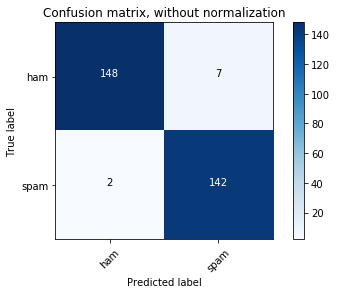

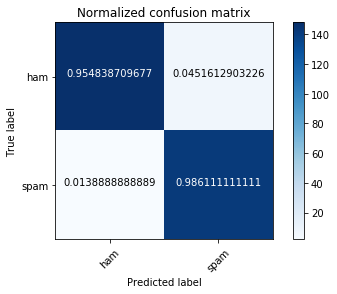

In [50]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, naive_model.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Получился довольно хороший результат. Видно, что в неспам попало только 2 сообщения со спамом.

<module 'matplotlib.pyplot' from '/home/bombonjane/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

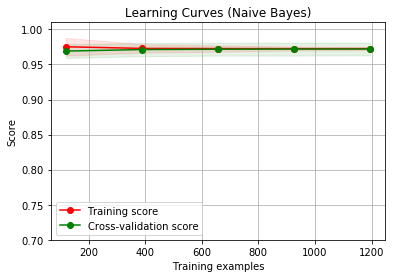

In [51]:
title = "Learning Curves (Naive Bayes)"
estimator = naive_model
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

Оценка обучения на тренировочной выборке сходится в 1 линию с тестовой. Кажется, здесь просто относительно высок процент ошибок (не поможет увеличение выборки).

Попробуем лес (на признаке длины он работал почти так же хорошо, как байес).

### Лес

In [53]:
rforest = RandomForestClassifier()
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [54]:
print(classification_report(rforest.predict(X_test), y_test))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.99       159
       spam       0.97      1.00      0.99       140

avg / total       0.99      0.99      0.99       299



Я вижу единицы, похоже, он опять переобучился:( Посмотрим матрицу.

### Матрица для леса

Confusion matrix, without normalization
[[155   0]
 [  4 140]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.03  0.97]]


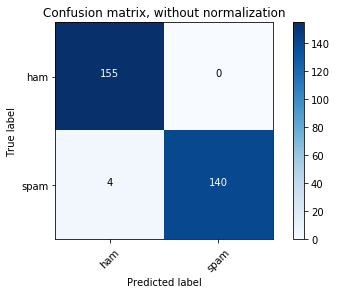

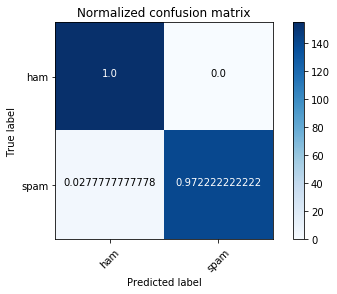

In [58]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rforest.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rforest.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rforest.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

<module 'matplotlib.pyplot' from '/home/bombonjane/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

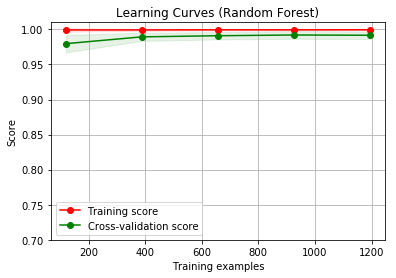

In [59]:
title = "Learning Curves (Random Forest)"
estimator = rforest
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

Внезапно хороший результат (я думала, cv будет меньше). С другой стороны, мы видим по матрицам, что байес более точно ловит спам (всего 2 ошибки FN, есть ошибки FP), а лес не делает ошибок в рапсознавании неспама (0 ошибок FP, но больше ошибок FN). Для задачи найти спам лучше всё же байес с разными признаками, а не только с длиной. 